# VGG16 Model | CIFAKE


In [1]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten
from keras.applications import VGG16
from keras.optimizers import Adamax
from keras.regularizers import L1, L2
from keras.losses import BinaryCrossentropy
from utils import (
    build_sequential_model,
    load_data,
    plot_performance_curves,
    save_model_history,
    load_model_history,
)
import PIL
from keras.callbacks import EarlyStopping

PIL.Image.MAX_IMAGE_PIXELS = None

In [2]:
model_name = "vgg16-regularized-adamax-epochs100_model_cifake"
dataset_base_path = "./datasets/CIFAKE"

# Forcefully train the model
force_model_train = True

# Don't save the model
no_save = False

In [3]:
# Load saved model and its history
model_history_loaded, classifier, history = load_model_history(model_name)

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = True

In [5]:
# Building model
if not model_history_loaded or force_model_train:
    classifier = build_sequential_model(
        layers=[
            base_model,
            Flatten(),
            BatchNormalization(),
            Dense(
                64,
                kernel_regularizer=L2(0.01),
                activity_regularizer=L1(0.01),
                bias_regularizer=L1(0.01),
                activation="relu",
            ),
            Dropout(0.4),
            Dense(32, activation='relu'),
            Dense(1, "sigmoid"),
        ],
        loss=BinaryCrossentropy(),
        optimizer=Adamax(learning_rate=0.001),
    )

In [6]:
# Model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [7]:
# Load augmented image generators
train_generator, validation_generator = load_data(
    dataset_base_path, augmented=False, batch_size=200
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [8]:
# Train model
if not model_history_loaded or force_model_train:
    history = classifier.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
    )
    history = history.history

Epoch 1/100
500/500 [==============================] - 134s 239ms/step - loss: 0.6624 - accuracy: 0.8722 - precision: 0.8547 - recall: 0.8968 - val_loss: 0.3021 - val_accuracy: 0.9301 - val_precision: 0.9158 - val_recall: 0.9473
Epoch 2/100
500/500 [==============================] - 33s 67ms/step - loss: 0.2404 - accuracy: 0.9395 - precision: 0.9403 - recall: 0.9386 - val_loss: 0.2416 - val_accuracy: 0.9247 - val_precision: 0.8818 - val_recall: 0.9808
Epoch 3/100
500/500 [==============================] - 33s 66ms/step - loss: 0.1728 - accuracy: 0.9531 - precision: 0.9554 - recall: 0.9506 - val_loss: 0.3053 - val_accuracy: 0.8916 - val_precision: 0.9927 - val_recall: 0.7890
Epoch 4/100
500/500 [==============================] - 33s 66ms/step - loss: 0.1382 - accuracy: 0.9625 - precision: 0.9654 - recall: 0.9594 - val_loss: 0.1493 - val_accuracy: 0.9481 - val_precision: 0.9814 - val_recall: 0.9135
Epoch 5/100
500/500 [==============================] - 33s 66ms/step - loss: 0.1177 - accu

In [9]:
# Save model
if not model_history_loaded or (force_model_train and not no_save) or not no_save:
    save_model_history(classifier, history, model_name)

INFO:tensorflow:Assets written to: ./models/vgg16-regularized-adamax-epochs100_model_cifake/model\assets


INFO:tensorflow:Assets written to: ./models/vgg16-regularized-adamax-epochs100_model_cifake/model\assets


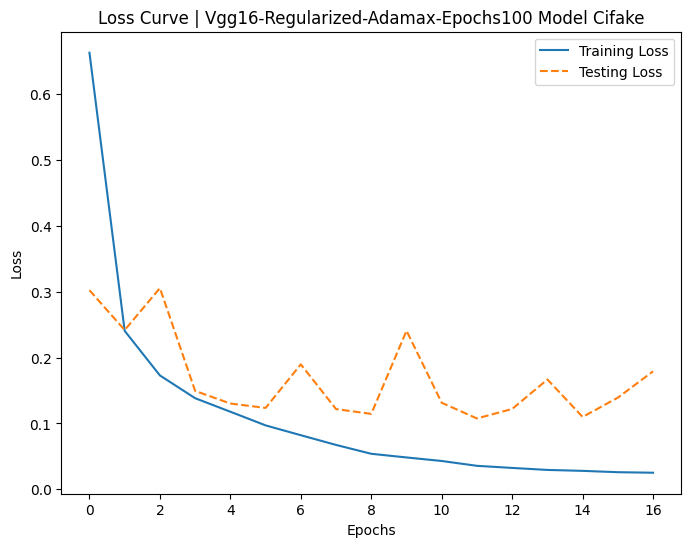

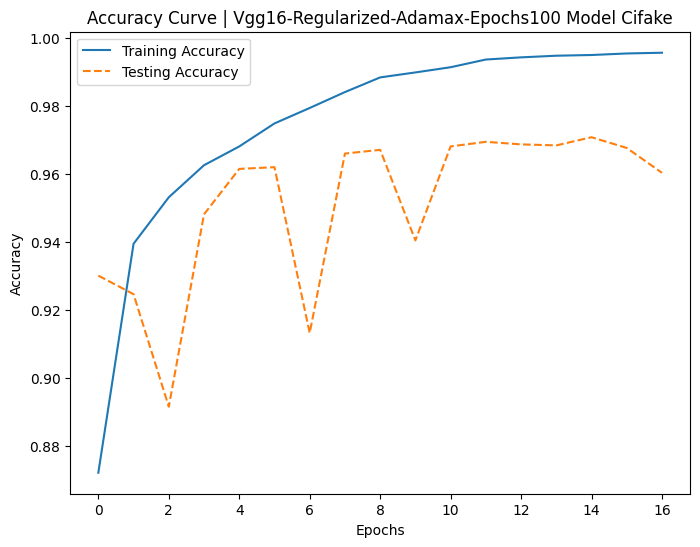

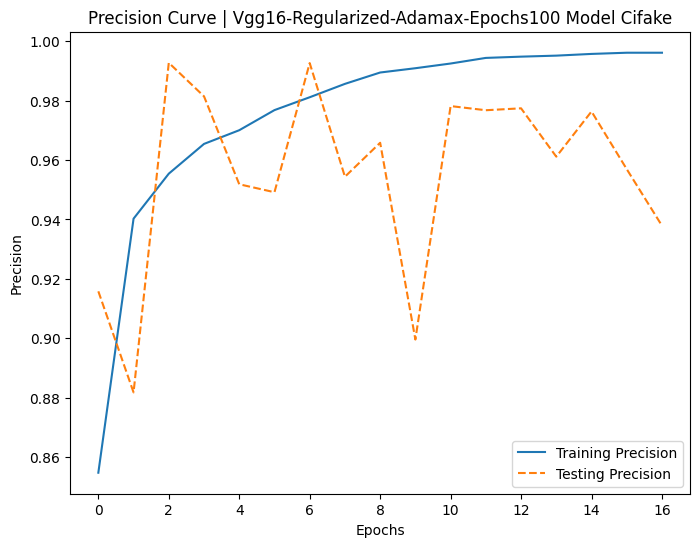

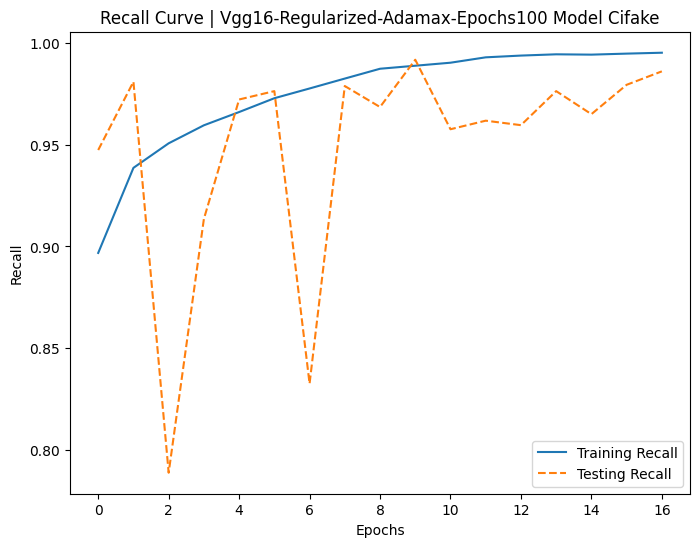

In [10]:
# Plot performance curves
plot_performance_curves(history, model_name)